# Setup

In [1]:
import numpy as np

import seaborn as sns
import pandas as pd
import polars as pl
import os
import pprint
import ast
import re
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import json

pp = pprint.PrettyPrinter(depth=6)

os.chdir(os.path.expanduser('~/vivarium-ecoli'))



# Get relevant indices

In [2]:
initial_state = json.load(open('data/vivecoli_t1.json'))

bulk_ids = [item[0] for item in initial_state['agents']['0']['bulk']]

In [3]:
# experiment = 'metabolism-redux-classic-minimal'
entry = f'sim_example'
folder = f'out/cofactors/{entry}/'
output_all = np.load(folder + '0_output.npy', allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

rna_listen = agent['rna_synth_prob_listener']
rna_count_listen = agent['RNA_counts_listener']
gene_ids = rna_listen.gene_ids
mrna_tu_ids = rna_count_listen.mRNA_TU_ids

bulk.columns = bulk_ids

for unique_key, bulk_id in [('active_ribosome', 'CPLX0-3962'), ('active_ribosome', 'CPLX0-3953'),
                            ('active_RNAP', 'APORNAP-CPLX')]:
    if unique_key in output['listeners']['unique_molecule_counts']:
        unique_count = output['listeners']['unique_molecule_counts'][unique_key]
        bulk.loc[:, bulk_id + '[c]'] += unique_count

In [4]:
# get specific indices
specific_gene_id = 'EG10282'
specific_gene_idx = gene_ids == specific_gene_id

specific_mrna_tu_id = 'TU0-14816[c]'
specific_mrna_tu_idx = mrna_tu_ids == specific_mrna_tu_id

specific_protein_id = 'FRUCBISALD-CLASSII[c]'
specific_protein_idx = bulk_ids.index(specific_protein_id)

# Save multi-gen timeseries

In [17]:
for i, cur_lineage in enumerate(['lineage_0', 'lineage_2', 'lineage_4', 'lineage_6']):
    folder = f'out/cofactors/lineage/'
    
    output = np.load(folder + cur_lineage + '.npy', allow_pickle='TRUE').item()['agents']['0']
    
    mass = output['listeners']['mass']['cell_mass']
    bulk = pd.DataFrame(output['bulk'])
    gene_counts = np.array(output['listeners']['rna_synth_prob']['gene_copy_number'][1:])
    rna_counts = np.array(output['listeners']['rna_counts']['mRNA_counts'][1:])
    
    bulk.columns = bulk_ids
    
    for unique_key, bulk_id in [('active_ribosome', 'CPLX0-3962'), ('active_ribosome', 'CPLX0-3953'),
                                ('active_RNAP', 'APORNAP-CPLX')]:
        if unique_key in output['listeners']['unique_molecule_counts']:
            unique_count = output['listeners']['unique_molecule_counts'][unique_key]
            bulk.loc[:, bulk_id + '[c]'] += unique_count
    
    mass = np.array(mass)[1:]
    gene_counts = gene_counts[:, specific_gene_idx].flatten()
    rna_counts = rna_counts[:, specific_mrna_tu_idx].flatten()
    protein_counts = bulk.loc[:, specific_protein_id].values[1:]
    
    # make a dataframe
    series_df = pl.DataFrame([mass, gene_counts, rna_counts, protein_counts],
                             schema=['mass', 'gene_counts', 'rna_counts', 'protein_counts'])
    
    # if i=0 create new df otherwise concatenate
    if i == 0:
        all_series_df = series_df
    else:
        all_series_df = pl.concat([all_series_df, series_df], how='vertical')
        
# add row index timestep
all_series_df = all_series_df.with_row_index(name='timestep')

In [21]:
# melt all_series_df
melt_series_df = all_series_df.melt(variable_name='variable', value_name='value', id_vars=['timestep'])

melt_series_df

melt_series_df.write_csv('notebooks/cofactors/data/lineage_timeseries.csv')

In [20]:
# make a plot
sns.relplot(data=melt_series_df, x='timestep', y='value', hue='variable', kind='line')

In [6]:
print(mass.shape, gene_counts.shape, rna_counts.shape, protein_counts.shape)

(1288,) (1288,) (1288,) (1288,)


In [2]:
lineage_order = ['lineage_0', 'lineage_2',  'lineage_4', 'lineage_6']

folder = f'out/cofactors/lineage/'

output_0 = np.load(folder + 'lineage_0.npy', allow_pickle='TRUE').item()['agents']['0']['listeners']['mass']['cell_mass']
output_2 = np.load(folder + 'lineage_2.npy', allow_pickle='TRUE').item()['agents']['0']['listeners']['mass']['cell_mass']
output_4 = np.load(folder + 'lineage_4.npy', allow_pickle='TRUE').item()['agents']['0']['listeners']['mass']['cell_mass']
output_6 = np.load(folder + 'lineage_6.npy', allow_pickle='TRUE').item()['agents']['0']['listeners']['mass']['cell_mass']


In [3]:
# save output_0+output_2+output_4+output_6 to a file
folder = f'notebooks/cofactors/data/'

output = output_0 + output_2 + output_4 + output_6
np.save(folder + 'lineage.npy', output)

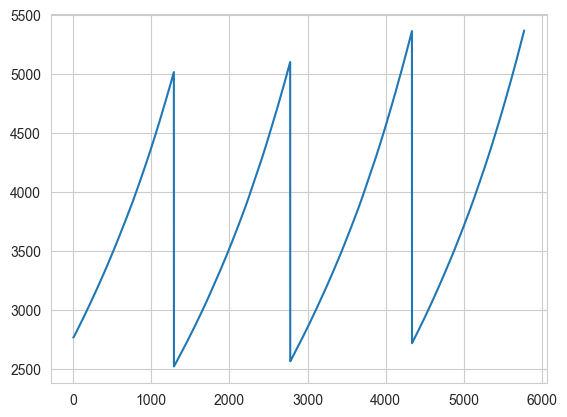

In [4]:
plt.plot(output_0+output_2+output_4+output_6, label='lineage')

In [3]:
# experiment = 'metabolism-redux-classic-minimal'
entry = f'sim_example'
folder = f'out/cofactors/{entry}/'
output_all = np.load(folder + '0_output.npy', allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

rna_listen = agent['rna_synth_prob_listener']
rna_count_listen = agent['RNA_counts_listener']
gene_ids = rna_listen.gene_ids
mrna_tu_ids = rna_count_listen.mRNA_TU_ids

# get protein counts
bulk.columns = bulk_ids

# in the bulk dataframe, update RNAP and 50S, 30S rib counts from unique molecules since they are sequestered as unique when in use.
for unique_key, bulk_id in [('active_ribosome', 'CPLX0-3962'), ('active_ribosome', 'CPLX0-3953'),
                            ('active_RNAP', 'APORNAP-CPLX')]:
    if unique_key in output['listeners']['unique_molecule_counts']:
        unique_count = output['listeners']['unique_molecule_counts'][unique_key]
        bulk.loc[:, bulk_id + '[c]'] += unique_count

# output['listeners']['unique_molecule_counts']['active_ribosome']
gene_counts = np.array(output['listeners']['rna_synth_prob']['gene_copy_number'][1:])

# convert to df
gene_counts_df = pl.DataFrame(gene_counts, schema=list(gene_ids))

# add timestep
gene_counts_df = gene_counts_df.with_row_index(name='timestep')

# melt to long format
gene_counts_df = gene_counts_df.melt(variable_name='gene', value_name='count', id_vars=['timestep'])

gene_counts_df.filter(pl.col('gene') == 'EG10584')
rna_counts = np.array(output['listeners']['rna_counts']['mRNA_counts'][1:])

# convert to df
rna_counts_df = pl.DataFrame(rna_counts, schema=list(mrna_tu_ids))

# add timestep
rna_counts_df = rna_counts_df.with_row_index(name='timestep')

# melt to long format
rna_counts_df = rna_counts_df.melt(variable_name='mRNA', value_name='count', id_vars=['timestep'])

# sort by count and print head
rna_counts_df.sort('count').tail()